# Hybrid recommendation algorithm
## Introduction:
Over the last two decades, recommender systems have become State-of-the-Art Algorithms and can be regarded as success factors for companies such as Google, Amazon, and Netflix 

<blockquote>The goal of a recommender system is to generate meaningful recommendations to a collection of users for items or products that might interest them. Suggestions for books on Amazon, or movies on Netflix, are real-world examples of the operation of industry-strength recommender systems. The design of such recommendation engines depends on the domain and the particular characteristics of the data available. For example, movie watchers on Netflix frequently provide ratings on a scale of 1 (disliked) to 5 (liked)</blockquote>

During my third year of bachelor's in Computer Sciences, I was introduced to the idea of recommender systems by a buddy of mine since then recommender systems been one of the most thought-provoking Machine learning algorithms for me. Today I'm going to introduce a recommendation algorithm that's a regression-based hybrid of content-based and collaborative filtering recommender systems. This Hybrid recommendation algorithm is highly inspired by the recommender systems approach of Andrew ng along with some research papers, I have attached in references

The dataset used is provided by [GroupLens](https://grouplens.org/about/what-is-grouplens/) and  can be downloaded from [here](https://grouplens.org/datasets/movielens/) it contains the following files(links.csv, movies.csv, ratings.csv, and tags.csv)

<blockquote>"This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996, and September 24, 2018. This dataset was generated on September 26, 2018."</blockquote>

generally, recommender systems falls into three categories
![title](images/categories.jpeg)


## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Accessing PostgreSQL Database Server from Python with ODBC
To establish a connection to my PostgreSQL Database Server I'm gonna be using odbc (Open Database Connectivity) that's the standard that says if you write to through this protocol this standard API then you can work with ODBC it accomplishes DBMS independence by using an ODBC driver as a translation layer between the application and the DBMS. The application uses ODBC functions through an ODBC driver manager with which it is linked, and the driver passes the query to the DBMS. An ODBC driver can be thought of as analogous to a printer driver or other driver, providing a standard set of functions for the application to use, and implementing DBMS-specific functionality. An application that can use ODBC is referred to as "ODBC-compliant". Any ODBC-compliant application can access any DBMS for which a driver is installed. Drivers exist for all major DBMSs and it's a plug-and-play kind of thing so there are drivers for ODBC for databases like Oracle, PostgreSQL, MySQL, and Microsoft SQL Server but you've to manually install DBMS of your choice and configure its driver before using it in your python code here I've already done it for PostgreSQL hence, I can use my PostgreSQL DRIVER named {PostgreSQL Unicode} in my code to establish the connection to PostgreSQL Database

<b> Please pay pilgrimage to PostgreSQLconnection class I have defined in PostgreSQL_Database_wrapper.py to understand the methods I'm going to use. I've provided docstrings for all methods that I'm going to use with my PostgreSQLconnection object here </b>

In [2]:
#importing PostgreSQLconnection class from my PostgreSQL_Database_wrapper file and creating an instance of it
from PostgreSQL_Database_wrapper import PostgreSQLconnection
db=PostgreSQLconnection("DRecommenderSystem_db","postgres","*******","localhost")

Successfully connected to database.


## Dataset
The dataset that I'm going to use for training my hybrid recommender algorithm is going to be the join of the Ratings and Movies tables created during EDA

In [3]:
query=  '''      
        SELECT Ratings.userId,Ratings.movieId,Ratings.rating,Movies.title
        FROM Ratings
        LEFT JOIN Movies
        ON Ratings.movieId = Movies.movieId;
        '''
data=db.run_query(query)
data.head()

,userid,movieid,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


# Feature engineering
Before introducing the hybrid recommender algorithm it's better to understand what kind of data recommender system algorithms works with. The data for Recommender system algorithms is almost always identical to the table above in place of movieId  it can be bookId, productId et cetera. The feature engineering step here involves the transformation of data into a user-item interaction matrix

<blockquote>User-item interaction matrices generally lists users and items in rows and columns, respectively. Then, the interaction records between them are represented as corresponding elements in the matrix</blockquote>


There are only two objectives of feature engineering to get data ready for training for this problem
## 1)Transform the data into matrix Y (user-item interaction matrix)

![title](images/Ymatrix.jpg)

In [4]:
MatrixData=data.drop(['title'], axis=1)
MovieUserMatrix = MatrixData.pivot_table(index='movieid',columns='userid',values='rating')
MovieUserMatrix.head()

userid,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieid,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
MovieUserMatrix_Y=MovieUserMatrix.fillna(-1)
MovieUserMatrix_Y

userid,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieid,,,,,,,,,,,,,,,,,,,,,
1,4.0,-1.0,-1.0,-1.0,4.0,-1.0,4.5,-1.0,-1.0,-1.0,...,4.0,-1.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,4.0,-1.0,-1.0,...,-1.0,4.0,-1.0,5.0,3.5,-1.0,-1.0,2.0,-1.0,-1.0
3,4.0,-1.0,-1.0,-1.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
193583,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
193585,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Transformation of data into matrix Y (user-item interaction matrix) (above)

## 2)Transform the data into matrix R (binary-valued indicator matrix)
![title](images/Rmatrix.jpeg)

In [6]:
MovieUserMatrix_R=MovieUserMatrix.copy()
MovieUserMatrix_R=MovieUserMatrix_R.where(~MovieUserMatrix_R.notna(), 1)
MovieUserMatrix_R=MovieUserMatrix_R.fillna(0)
MovieUserMatrix_R

userid,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieid,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Transformation of the data into matrix R (binary-valued indicator matrix) above

In [7]:
#sanity check
MovieUserMatrix_Y.shape==MovieUserMatrix_R.shape

True

In [8]:
#getting values out of pandas dataframe into numpy-array because my alogorithm accept numpy-array as parameter
Y=MovieUserMatrix_Y.values
R=MovieUserMatrix_R.values

# Hybrid recommendation approach 

The hybrid recommendation system that I'm going to implement consists of the following sequence of steps
1. <b>Collaborative filtering</b>:(Used to learn Features for movies)
2. <b>Content-based filtering</b>:(Used to learn Parameters unique to web-application user)
3. <b>Prediction</b>: (uses both the Features for movies learned using collaborative filtering and the Parameters unique to web-application user learned using content-based filtering to recommend top-N recommendation)
![title](images/Hybrid.jpeg)



# 1. Collaborative filtering
The main objective of collaborative filtering at this step is to learn features for different movies. The implementation of Collaborative filtering here performs "Feature learning" Using a variation of multivariate regression with gradient descent as an optimization algorithm, it takes as input user-item interaction matrix and simultaneously learns both the parameters for different users and features for different movies I'm only going to use Features for different movie in the next step but this technique of using both the parameters for users and feature for movies to learn both simultaneously works beautifully for a problem like recommender systems because this approach unlike content-based filtering doesn't require features for different movies to learn parameters for users or parameters for users to learn features for different movies all you need is a user-item interaction matrix and this algorithm will learn a reasonably good set of both the parameters for users and features for movies because it's a modification of multivariate regression whose optimization objective is a concave cost function that always converges towards global minima regardless of your initial values for both the parameters of users and features for different movies. Once features for movies have been learned by collaborative filtering I'm going to save them in python's [.PKL] file that serializes objects to files on disk and deserialized back into the program at runtime when needed 

## Notations
* <B>x(i)</B> is a feature vector for movie(i)
* <B>θ(j)</B> is a parameter vector for user(j)
* The <B>matrix Y</B> (user-item interaction matrix) stores the ratings (from 1 to 5) for all movies(i) by all users(j) where <B>y(i;j)</B> represet the rating for movie(i) by user (j)
* The <B>matrix R</B> is a binary-valued indicator matrix, where r(i; j) = 1 if user j gave a rating to movie i, and r(i; j) = 0 otherwise.
* <b>nu</b> = total number of users
* <b>nm</b> = total number of movies.
For this project, I'm using n = 100, and therefore, x(i) ∈ R^100 and θ(j) ∈  R^100.



##  Collaborative filtering Cost function
The cost function for this Regression-based collaborative filtering algorithm is going to be of the following form:
![title](images/costfunc.jpg)


## Collaborative filtering Regularized cost function
The Regularized cost function for this Regression-based collaborative filtering algorithm is going to be of the following form:
![title](images/costfuncRegularized.jpg)

## Gradient for Collaborative filtering Cost function
The gradient for Collaborative filtering Cost function is as follows:
![title](images/costfuncGradient.jpg)

## Gradient for Collaborative filtering Regularized Cost function
Gradient for Collaborative filtering Regularized Cost function is as follows:
![title](images/costfuncGradientRegularized.jpg)


In [9]:
#Implementation of Collaborative filtering Cost function and gradient, regularized and non regularized
def  cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
            calculates Collaborative filtering Cost function and gradient both regularized and non regularized
            
            Parameters
            ----------
            params: numpy array-like
                    initial values for users parameter vectors and movies feature vectors
            
            Y: numpy array-like
                    user-item interaction matrix
            R: numpy arra-like
                    Its a binary-valued indicator matrix for user-item interaction matrix
            num_users: int-like
                    total number of users
            num_movies: int-like
                    total number of movies
            Lambda: Float-like
                    Regularization parameter
                    
            Returns
            -------
            J:Float-like
                    Cost
            grad:Float-like
                    Gradient
            reg_J:Float-like
                    Regularized Cost
            reg_grad:Float-like
                    Regularized gradient
    """
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  np.dot(X,Theta.T)
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)# multiplying by R will consider only those values for which value of (i,j)=r(i,j)=1
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = np.dot(err*R,Theta)
    Theta_grad = np.dot((err*R).T,X)
    grad = np.append(X_grad.flatten(),Theta_grad.flatten()) #flattening calculated gradients of 4*3 dim into 12 real number one dim of vector for optimization algo since optimization algorithms deals with vectos not matrix 
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    #, reg_J, reg_grad
    
    return J, grad, reg_J, reg_grad

## Gradient descent
Numerical optimization algorithm to minimize the Collaborative filtering Cost function By noting α ∈ R the learning rate, the update rule for gradient descent
is expressed with the learning rate and the cost function J as follows:
![title](images/GD.jpg)


In [10]:
#Gradient descent implementation
def gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
            Optimize X and Theta
            
            Parameters
            ----------
            initial_parameters: numpy array-like
                    initial values for users parameter vectors and movies feature vectors
            
            Y: numpy array-like
                    user-item interaction matrix
            R: numpy arra-like
                    Its a binary-valued indicator matrix for user-item interaction matrix
            num_users: int-like
                    total number of users
            num_movies: int-like
                    total number of movies
            alpha: Float-lik
                    learning rate
            num_iters: integer-like
                    number of iterations of optimization algorithm
            Lambda: Float-like
                    Regularization parameter
                    
            Returns
            -------
            paramsFinal: numpy-array-like
                    Learned user parameters and feature vectors for movies
            J_history: numpy-array-like
                     History of decrease in cost as gradeint descent moves towords global minima
    """
    # unfold the parameters
    X = initial_parameters[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = initial_parameters[num_movies*num_features:].reshape(num_users,num_features)
    
    J_history =[]
    
    for i in range(num_iters):
        params = np.append(X.flatten(),Theta.flatten())
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        X_grad = grad[:num_movies*num_features].reshape(num_movies,num_features)
        Theta_grad = grad[num_movies*num_features:].reshape(num_users,num_features)
        X = X - (alpha * X_grad)
        Theta = Theta - (alpha * Theta_grad)
        J_history.append(cost)
    
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

In [11]:
def normalizeRatings(Y, R):
    """
    normalized Y so that each movie has a rating of 0 on average, and returns the mean rating in Ymean.
    
    Parameters
    ----------
    Y: numpy array-like
                    user-item interaction matrix
    R: numpy arra-like
                    Its a binary-valued indicator matrix for user-item interaction matrix
    Ynorm:numpy array-like
                    Normalize Y
    Ymean:numpy array-like
                    Mean of all movies
    """
    
    m,n = Y.shape[0], Y.shape[1]
    Ymean = np.zeros((m,1))
    Ynorm = np.zeros((m,n))
    
    for i in range(m):
        Ymean[i] = np.sum(Y[i,:])/np.count_nonzero(R[i,:])
        Ynorm[i,R[i,:]==1] = Y[i,R[i,:]==1] - Ymean[i]
    return Ynorm, Ymean

# 2. Content-based filtering
The content-based filtering here again is going to be an extension of multivariate regression but unlike collaborative filtering here I'm going to use the features for movies learned using collaborative filtering now to learn online web-application user parameter using content-based filtering thats unique to the user based on his/her web application movie ratings.This content-based filtering algorithm will run and learn online the parameters unique to each web-application user  but this algorithm by no means a type of Online learning algorithm because that definition strictly includes the ability of algorithm to use sequential data coming as input online and use it to update the best predictor for future data at each step

## Notations
* <B>x(i)</B> is a feature vector for movie(i)
* <B>θ</B> is a parameter vector for web-applicaiton user
* <b>y(i)</b> i the rating for movie i by web-applicaiton user
* r(i) = 1 if web-applicaiton user gave a rating to movie i, and r(i) = 0 otherwise.

.
I'm using n = 100, and therefore, x(i) ∈ R^100 and θ ∈  R^100.




## Content-based filtering Cost function
![title](images/CBcost.jpg)

In [12]:
def computeCost(X, y, theta):
    """
            calculates cost for given value of θ 
            
            Parameters
            ----------
            X: numpy-array-like
               matrix of features for all movies
               
            y: numpy-array-like
               binary vector of web-application user movie ratings (y ∈ R^9742) where 9742 is the number of movies rated by web-app user
                    
            theta:numpy-array-like
               value of θ for web application user
               
            Returns
            -------
            j: float-like
               cost
    """
    m=y.size
    s=np.dot(X,theta)-y
    j=(1/(2*m))*(np.dot(np.transpose(s),s))
    return j


## Gradient descent
Numerical optimization algorithm to minimize the Content-based filtering  Cost function By noting α ∈ R the learning rate, the update rule for gradient descent is expressed with the learning rate and the cost function J as follows:

![title](images/CF.jpg)

In [13]:
def CBgradientDescent(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.
    
    Parameters
    ----------
    X : array_like
        matrix of features for all movies
    
    y : array_like
        binary vector of ∈ R^9742 movies where 9742 is the number of movies
    
    theta : array_like
        Initial values for the web-applicaiton user parameters. 
    
    alpha : float
        The learning rate.
    
    num_iters : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned parameters. 
    """
    m = float(y.shape[0])
    theta = theta.copy()
    for i in range(num_iters):
        theta=(theta)-(alpha/m)*(np.dot(np.transpose((np.dot(X,theta)-y)),X))
    return theta

# 3. Prediction
Prediction (uses both the Features for movies learned using collaborative filtering and the Parameters unique to user learned using content-based filtering to recommend top-N recommendation)
The prediction uses both the vectors for movies learned using collaborative filtering and the parameter unique to user learned using content-based filtering to recommend top-N recommendation

The  prediction logic for my web application user is pretty straightforward I'm going to predict the score for all 9742 movies, where each prediction is a linear combination of Movie feature vector (x) learned using Collaborative filtering  and Feature vector for web-application user θ  learned using content-based filtering


![title](images/predi.jpg)

In [14]:
def prediction(X,my_ratings,moviesdataset):
    """
    Performs prediction.
    
    Parameters
    ----------
    X : array_like
        matrix of features for all movies
    
    my_ratings : numpy-array-like
        Binary vector of web-application user movie ratings (y ∈ R^9742) where 9742 is the number of movies rated by web-app user
                    
    moviesdataset : pandas dataframe-like
        Dataframe contains movieid and title for all 9742 movies
    
    Returns
    -------
    sorted_data : array_like
        top-N recommendation
    
    """
    out_arr = my_ratings[np.nonzero(my_ratings)]
    out_arr=out_arr.reshape(-1,1)
    idx = np.where(my_ratings)[0]
    X_1=[X[x] for x in idx]
    X_1=np.array(X_1)
    y=out_arr
    y=np.reshape(y, -1)
    theta =CBgradientDescent(X_1,y,np.zeros((100)),0.001,4000)
    #mean=np.reshape(Ymean, -1)
    p = X @ theta.T
    #p=p+mean
    p=np.reshape(p, -1)
    predictedData=moviesdataset.copy()
    predictedData['Pridiction']=p
    sorted_data=predictedData.sort_values(by=['Pridiction'],ascending=False)
    return sorted_data[:40]


# Training and Evaluation of Recommendation Model
Unlike classification and regression problems, there is no hard-and-fast rule when it comes to the evaluation of recommender systems At the end of the day, system designer employing a recommendation system must choose between a set of candidate approaches 


## Train-Test split
For Train-Test split, there are again numerous techniques available [this](https://arxiv.org/pdf/2007.13237.pdf) paper is a great read on this subject for this project I will split my data into training and test sets by removing 10 ratings per user from the training set and placing them in the test set.

In [15]:
def train_test_split(Yratings,Rratings):
    """
    train and test split
    Parameters
    ----------
    Yratings: numpy array-like
                    user-item interaction matrix
    Rratings: numpy arra-like
                    Its a binary-valued indicator matrix for user-item interaction matrix
                    
    Returns
    -------
    Ytrain: numpy array-like
                   train user-item interaction matrix
    Ytest:  numpy array-like
                   test user-item interaction matrix
    Rtrain: numpy array-like
                   train its a binary-valued indicator matrix for user-item interaction matrix
    Rtest:  numpy array-like
                   test its a binary-valued indicator matrix for user-item interaction matrix
    
    """
    Ytest = np.zeros(Yratings.shape)
    Ytrain = Yratings.copy()
    Rtest = np.zeros(Rratings.shape)
    Rtrain = Rratings.copy()
    
    for user in range(Yratings.shape[0]):
        try:
            test_ratings = np.random.choice(Yratings[user, :].nonzero()[0], 
                                            size=10, 
                                            replace=False)
            Ytrain[user, test_ratings] = 0.
            Ytest[user, test_ratings] = Yratings[user, test_ratings]
            
            Rtrain[user, test_ratings] = 0.
            Rtest[user, test_ratings] = Rratings[user, test_ratings]
        except ValueError:
            test_ratings = np.random.choice(Yratings[user, :].nonzero()[0], 
                                            size=10, 
                                            replace=True)
            Ytrain[user, test_ratings] = 0.
            Ytest[user, test_ratings] = Yratings[user, test_ratings]
            
            Rtrain[user, test_ratings] = 0.
            Rtest[user, test_ratings] = Rratings[user, test_ratings]
    # Test and training are truly disjoint
    assert(np.all((Ytrain * Ytest) == 0))
    assert(np.all((Rtrain * Rtest) == 0))
    return Ytrain, Ytest, Rtrain, Rtest

Text(0.5, 1.0, 'Cost function using Gradient Descent')

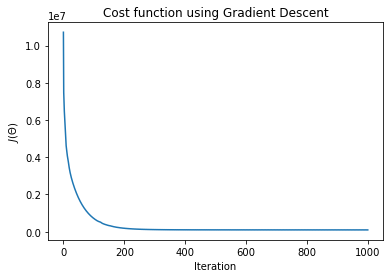

In [17]:
#Train-Test split
Ytrain, Ytest, Rtrain, Rtest = train_test_split(Y,R)
num_users = Ytrain.shape[1]
num_movies = Ytrain.shape[0]
num_features = 100

# Set initial Parameters (Theta,X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.append(X.flatten(),Theta.flatten())
Lambda = 10

# learns Features for movies and parameters for all users using Collaborative filtering
paramsFinal, J_history = gradientDescent(initial_parameters,Ytrain,Rtrain,num_users,num_movies,num_features,0.001,1000,Lambda)

plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
X = paramsFinal[:num_movies*num_features].reshape(num_movies,num_features)
Theta = paramsFinal[num_movies*num_features:].reshape(num_users,num_features)

The above curve informs that the Collaborative filtering is indeed working and with each iteration of Gradient descent the cost of my cost function is going down and plateaued out around 200 and from there onwards the change is constant 

## Learning Curve Analysis
For the evaluation of recommender systems, I'm going to use the MSE metric but just calculating MSE  alone for both train and test set means nothing I need to perform a learning curve analysis to better understand the quality of my model performance to that end I will train my model on different sizes of train set and evaluate both the training and test set MSE score for a given size of train and test set and let the learning curves guide me to the further improvement of my model based on the result of the learning curve my model can be suffering from bias problem, variance problem or if I'm lucky enough then I will in goldilock zone which is the ideal situation.


<b>NOTE</b>: the dataset used in this notebook is the smallest available on  MovieLens of only 1 MB this one is only intended for educational purposes hence the learning curves are not going to be ideal by any means but I've trained the final model that I've deployed on 265 MB dataset from movieLens 

In [18]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [23]:
def learningCurve(Ytrain,Rtrain,Ytest,Rtest):
    """
    compute data for learning Curve
                    
    Parameters
    -------
    Ytrain: numpy array-like
                   train user-item interaction matrix
    Ytest:  numpy array-like
                   test user-item interaction matrix
    Rtrain: numpy array-like
                   train its a binary-valued indicator matrix for user-item interaction matrix
    Rtest:  numpy array-like
                   test its a binary-valued indicator matrix for user-item interaction matrix
                   
    Returns
    -------
    
    train_size_hist: numpy array-like
                   different training set sizes used
    train_score_hist: numpy array-like
                   scores relative to training size
    test_size_hist: numpy array-like
                   different test set sizes used
    test_score_hist: numpy array-like
                   scores relative to training size
    
    """
    Y=Ytrain
    R=Rtrain
    test_Y=Ytest
    test_R=Rtest
    train_size_hist=[]
    train_score_hist=[]
    test_size_hist=[]
    test_score_hist=[]
    size_list=[1,100,800,1000,1500,2000,2500,3000,3300,3800,4800,5900,6500,7000,7600,8300,9724]
    for size in size_list:
        Ytrain=Y[:size]
        Rtrain=R[:size]
        Ytest=test_Y[:size]
        Rtest=test_R[:size]
        num_users = Ytrain.shape[1]
        num_movies = Ytrain.shape[0]
        num_features = 100

        # Set initial Parameters (Theta,X)
        X = np.random.randn(num_movies, num_features)
        Theta = np.random.randn(num_users, num_features)
        initial_parameters = np.append(X.flatten(),Theta.flatten())
        Lambda = 10

        # Optimize parameters using Gradient Descent
        paramsFinal, J_history = gradientDescent(initial_parameters,Ytrain,Rtrain,num_users,num_movies,num_features,0.001,1000,Lambda)
        X = paramsFinal[:num_movies*num_features].reshape(num_movies,num_features)
        Theta = paramsFinal[num_movies*num_features:].reshape(num_users,num_features)
        pred = X @ Theta.T
        pred=pred*Rtrain
        actual=Ytrain
        train_size_hist.append(size)
        train_score_hist.append(get_mse(pred, actual))
        pred = X @ Theta.T
        pred=pred*Rtest
        actual=Ytest
        test_size_hist.append(size)
        test_score_hist.append(get_mse(pred, actual))
    return train_size_hist,train_score_hist,test_size_hist,test_score_hist

In [24]:
train_size_hist,train_score_hist,test_size_hist,test_score_hist=learningCurve(Ytrain,Rtrain,Ytest,Rtest)

(0.97, 1.05)

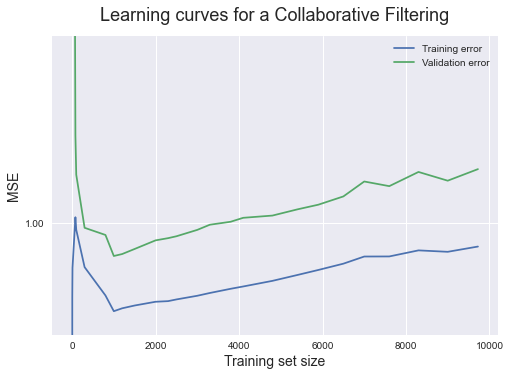

In [40]:
plt.style.use('seaborn')
plt.plot(train_size_hist, train_score_hist, label = 'Training error')
plt.plot(train_size_hist, test_score_hist, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.yticks(np.arange(0,2, 0.25))
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Collaborative Filtering', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.97,1.05)

## Observation:
As I mentioned earlier the dataset used in this notebook is the smallest available on  MovieLens of only 1 MB this one is only intended for educational purposes hence these learning curves are not ideal by any means more specifically the gap between the two learning curves suggests a substantial increase in variance. The low training MSEs corroborate this diagnosis of high variance. The large gap and the low training error also indicate an overfitting problem. Overfitting happens when the model performs well on the training set, but far poorer on the test (or validation) set. One more important observation we can make here is that adding new training instances is very likely to lead to a better model that's exactly what I did and trained my model for the 265 MB dataset from movieLens. another thing to be noted here is the sizes used for learning curves are randomly cherry-picked by me if the learning curve analysis is performed for every possible size the learning curves will be much smoother



In [41]:
#cleaning and transforming moviesDataset to use it on web-application 
moviesdataset=data.drop(['userid','rating'],axis=1)
moviesdataset=moviesdataset.drop_duplicates()
moviesdataset=moviesdataset.sort_values("movieid")
moviesdataset=moviesdataset.reset_index(drop=True)
moviesdataset["title"] = moviesdataset["title"].str.lower() 
moviesdataset["title"] = moviesdataset["title"].str.replace(r"\(.*\)","")
moviesdataset.head()

,movieid,title
0,1,toy story
1,2,jumanji
2,3,grumpier old men
3,4,waiting to exhale
4,5,father of the bride part ii


## Testing 
Now at this point, I'm all set to start the <b> flask web application</b>  development but before moving onwards I'm just going to test if everything working with my content-based filtering algorithm for that end I'm going to test my content-based filtering algorithm out
I've already learned the feature vectors for all movie using a collaborative filtering algorithm now as a new user on web application rates a handful of movies my content-based filtering algorithm will use learned the feature vectors for all movies using collaborative filtering algorithm and ratings by the web application user to learn parameter unique to this web-application user and then perform the linear combination prediction logic to recommend top-N-movies

In [42]:
# Initialize my ratings
my_ratings = np.zeros((9724,1))

# test rating by web-applicaiton user
my_ratings[0] = 4 
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[82]= 4
my_ratings[225] = 5
my_ratings[354]= 5

print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i]>0:
        print("Rated",int(my_ratings[i]),"for Movie")
        print((moviesdataset.iloc[i]).title)

New user ratings:

Rated 4 for Movie
toy story 
Rated 3 for Movie
sabrina 
Rated 5 for Movie
dracula: dead and loving it 
Rated 4 for Movie
indian in the cupboard, the 
Rated 5 for Movie
fair game 
Rated 3 for Movie
misérables, les 
Rated 5 for Movie
screamers 
Rated 4 for Movie
vampire in brooklyn 
Rated 2 for Movie
braveheart 
Rated 5 for Movie
little women 
Rated 5 for Movie
above the rim 


In [43]:
# top-N-movies
prediction(X,my_ratings,moviesdataset)

,movieid,title,Pridiction
5658,27667,ju-on: the curse,5.006813
68,76,screamers,5.000000
354,409,above the rim,5.000000
225,261,little women,5.000000
63,71,fair game,5.000000
11,12,dracula: dead and loving it,5.000000
9474,170401,table 19,4.796291
5358,8954,lightning in a bottle,4.791735
8777,130052,clown,4.534622
3163,4263,days of wine and roses,4.482884


# Save learned Features for movies
Nextly I will start flask web application development and for that I will use the feature vectors for all movies learned using a collaborative filtering algorithm to that end I'm going to save them and load them in flask web application

In [44]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(X, 'Movies_Learned_Features.pkl')
joblib.dump(moviesdataset, 'Movies_Datase.pkl')
  

['Movies_Datase.pkl']

# Next Step

The next step is flask web application development and deployment. Flask web application development code is available in the server directory